<a href="https://colab.research.google.com/github/halfChewedGum/ECON626Competitions/blob/main/ECON626_final_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from google.colab import files
uploaded = files.upload()

Saving 02_wrk_data_train.csv to 02_wrk_data_train (1).csv


In [2]:
import io
df = pd.read_csv(io.BytesIO(uploaded['02_wrk_data_train.csv']))
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,dollar_price,date_crawled,name,vehicle_type,registration_year,gearbox,power_ps,...,unrepaired_damage,ad_created,postal_code,last_seen_online,price,year,km,damage,age,log_prices
0,0,0,0,900.0,2016-03-26,Renault_Kangoo_1.4__TÃƒÂœV_01/2018__1._Hand,0,2016,0,75,...,ja,2016,82256,2016-04-06,900.0,2016,150000,1.0,0,6.802395
1,1,1,1,7100.0,2016-03-29,BMW_116d_DPF,0,2009,0,116,...,nein,2016,30457,2016-03-30,7100.0,2009,90000,0.0,7,8.867850
2,2,2,2,500.0,2016-03-23,Volkswagen_Lupo_1.4,1,1999,0,75,...,ja,2016,87734,2016-03-23,500.0,1999,150000,1.0,17,6.214608
3,3,3,3,35000.0,2016-03-14,Mercedes_Ponton_180b_Oldtimer,0,1961,0,68,...,nein,2016,22941,2016-03-17,35000.0,1961,150000,0.0,55,10.463103
4,4,4,4,3700.0,2016-03-10,Fiat_Andere,2,1972,0,52,...,ja,2016,6901,2016-04-06,3700.0,1972,100000,1.0,44,8.216088


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          200000 non-null  int64  
 1   Unnamed: 0.1        200000 non-null  int64  
 2   Unnamed: 0.1.1      200000 non-null  int64  
 3   dollar_price        200000 non-null  float64
 4   date_crawled        200000 non-null  object 
 5   name                200000 non-null  object 
 6   vehicle_type        200000 non-null  int64  
 7   registration_year   200000 non-null  int64  
 8   gearbox             200000 non-null  int64  
 9   power_ps            200000 non-null  int64  
 10  kilometer           200000 non-null  int64  
 11  registration_month  200000 non-null  int64  
 12  fuel_type           200000 non-null  int64  
 13  unrepaired_damage   166707 non-null  object 
 14  ad_created          200000 non-null  int64  
 15  postal_code         200000 non-nul

In [3]:
#normalizer 
from sklearn import preprocessing

def norm_predictors(x):
  """ Takes in a dataframe X and returns a normalized version using MinMaxScaling"""
  cols = list(x.columns)
  x = np.array(x)  
  minMax = preprocessing.MinMaxScaler()
  x_scale = minMax.fit_transform(x)
  df = pd.DataFrame(x_scale, columns = cols)

  return df 

ndf = norm_predictors(df[['power_ps', 'kilometer','age', 'log_prices']])
ndf.head(3)

,power_ps,kilometer,age,log_prices
0,0.00375,1.000000,0.000000,0.095271
1,0.00580,0.586207,0.098592,0.430050
2,0.00375,1.000000,0.239437,0.000000


In [4]:
df['power_ps'] = ndf['power_ps']
df['kilometer'] = ndf['kilometer']
df['age'] = ndf['age']
df['log_prices'] = ndf['log_prices']


In [5]:
#add classification of prices

prices = np.array(df['dollar_price'])
price_class_list = [x for x in prices]

for i in range(len(price_class_list)):
  if price_class_list[i] > 3500:
    price_class_list[i] = 1
  else:
    price_class_list[i] = 0

price_class_arr = np.array(price_class_list)
df['price_class'] = pd.Series(price_class_arr)

df.head(3)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,dollar_price,date_crawled,name,vehicle_type,registration_year,gearbox,power_ps,...,ad_created,postal_code,last_seen_online,price,year,km,damage,age,log_prices,price_class
0,0,0,0,900.0,2016-03-26,Renault_Kangoo_1.4__TÃƒÂœV_01/2018__1._Hand,0,2016,0,0.00375,...,2016,82256,2016-04-06,900.0,2016,150000,1.0,0.000000,0.095271,0
1,1,1,1,7100.0,2016-03-29,BMW_116d_DPF,0,2009,0,0.00580,...,2016,30457,2016-03-30,7100.0,2009,90000,0.0,0.098592,0.430050,1
2,2,2,2,500.0,2016-03-23,Volkswagen_Lupo_1.4,1,1999,0,0.00375,...,2016,87734,2016-03-23,500.0,1999,150000,1.0,0.239437,0.000000,0


In [10]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'dollar_price',
       'date_crawled', 'name', 'vehicle_type', 'registration_year', 'gearbox',
       'power_ps', 'kilometer', 'registration_month', 'fuel_type',
       'unrepaired_damage', 'ad_created', 'postal_code', 'last_seen_online',
       'price', 'year', 'km', 'damage', 'age', 'log_prices', 'price_class'],
      dtype='object')

In [6]:
# dataset to work with: 

x = df[['vehicle_type', 'registration_year','gearbox','power_ps', 'kilometer', 'fuel_type', 'postal_code', 'damage', 'age']]
y = df['price_class']


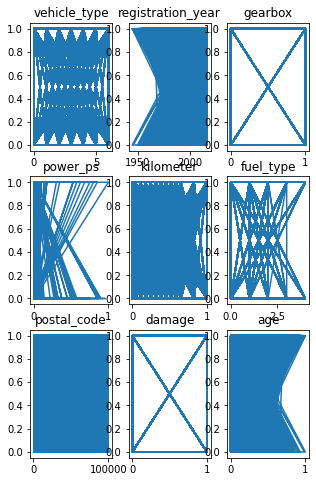

In [25]:
#visualizations 
fig_size = (5,8)
fig = plt.figure(figsize = fig_size)
grid = fig.add_gridspec(3,3)

def draw_plot(dx, dy, title, f, locx, locy):
  ax = f.add_subplot(grid[locx, locy])
  ax.plot(dx, dy)
  ax.set(title = title)

  return f

locs = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]

x_cols = list(x.columns)

for col in x_cols:
  draw_plot(df[col], y, col, fig, locs[x_cols.index(col)][0], locs[x_cols.index(col)][1])


# CLASSIFICATION ALGORITHMS 

1. KNN
2. Decision Tree
3. Random Forest
4. Logistic Regression
5. SVM


In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state = 0)

### KNN

In [27]:
#KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def find_best_k(x,y, x_val, y_val):
    """
    find best K for KNN
    """
    accuracy = []
    
    for i in range(1,21):
        knn = KNeighborsClassifier(n_neighbors = i).fit(x,y)
        preds = knn.predict(x_val)
        accuracy.append(metrics.accuracy_score(y_val, preds))
        
    return max(accuracy), accuracy
    
bestK = find_best_k(x_train, y_train, x_val, y_val)[0]
acc = find_best_k(x_train, y_train, x_val, y_val)[1]

indices = [i for i, x in enumerate(acc) if x == bestK]

print("best accuracy is: ", bestK)
print("best k for this: ", indices)



best accuracy is:  0.7840166666666667
best k for this:  [2]


Best K = 2 

Accuracy : 78%

----

Now, find the best features for KNN

In [ ]:
#best features

k = 2


#Backward (Recursive)  
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold


def make_models():
    """
    Use RFE to build different models with different numbers of features 
    Returns a dictionary of all the different models 
    """
    models = dict()
    for i in range(1,10):
        rfe = RFE(estimator = KNeighborsClassifier(), n_features_to_select = i)
        model = KNeighborsClassifier(n_neighbors = k)
        models[str(i)] = Pipeline(steps = [('s', rfe),('m', model)])
    
    return models 
 
def evaluate_model(model, x, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, x, y, cv= cv, scoring = 'accuracy',n_jobs=-1)
    scores = np.absolute(scores)
    
    return scores
    
models = make_models()
results = []
model_name = []


for name, model in models.items():
    scores = evaluate_model(model, x_train, y_train)
    results.append(scores)
    model_name.append(name)
    
    
    print("Model %s has score of %.3f" %(name, np.mean(scores)))




All 9 features must be included. 0.76 accuracy.


In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [30]:



knn = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)
knn_preds = knn.predict(x_val)
knn_acc = accuracy_score(y_val, knn_preds)

print("KNN accuracy: ", knn_acc)



KNN accuracy:  0.7651833333333333


In [16]:
def build_conf_mat(y, pr, alg):
  confMat = confusion_matrix(y, pr)

  print(alg, " Confusion Matrix: ")
  
  confMat_df = pd.DataFrame(confMat, columns = ['TP&FN', 'FP&TN'])
  print(confMat_df)

  sns.heatmap(confMat/np.sum(confMat), annot=True, fmt='.2%') 

KNN-K=2  Confusion Matrix: 
   TP&FN  FP&TN
0  27691   2888
1  11201  18220


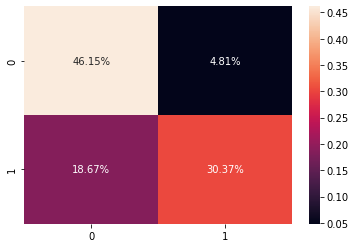

In [33]:
build_conf_mat(y_val, knn_preds, 'KNN-K=2')

In [15]:
# precision and recall measures 

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


def calc_precision(y, pr, alg):
  """
  Function calculates precision and recall for any Classification algorithm
  """
  precision = precision_score(y, pr, average = 'micro')
  print('Precision: %.3f' % precision, ' for ', alg)
  recall = recall_score(y, pr, average = 'micro')
  print('Recall: %.3f' % recall, 'for ', alg)


In [35]:
calc_precision(y_val, knn_preds, 'KNN-K=2')

Precision: 0.765  for  KNN-K=2
Recall: 0.765 for  KNN-K=2


In [36]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy='most_frequent').fit(x_train, y_train)
pred_most_frequent = dummy_majority.predict(x_val)

print("Test score: {:.2f}".format(dummy_majority.score(y_val, pred_most_frequent)))

#basically only predicting 1 class! 

Test score: 1.00


### Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier

x_train_arr = np.array(x_train)
x_val_arr = np.array(x_val)


y_train_arr = np.array(y_train).reshape(-1,1)
y_val_arr = np.array(y_val).reshape(-1,1)


tr = DecisionTreeClassifier(random_state = 0, max_depth = 7)
tr.fit(x_train_arr, y_train_arr)
pred_tree = tr.predict(x_val_arr)
pred_tree = pred_tree.reshape(-1,1)

from sklearn.metrics import classification_report, confusion_matrix

print('Decision Tree: ', confusion_matrix(y_val_arr, pred_tree))
print('Reports: ', classification_report(y_val_arr, pred_tree))

Decision Tree:  [[27588  2991]
 [ 4696 24725]]
Reports:                precision    recall  f1-score   support

           0       0.85      0.90      0.88     30579
           1       0.89      0.84      0.87     29421

    accuracy                           0.87     60000
   macro avg       0.87      0.87      0.87     60000
weighted avg       0.87      0.87      0.87     60000



DecisionTree  Confusion Matrix: 
   TP&FN  FP&TN
0  27588   2991
1   4696  24725


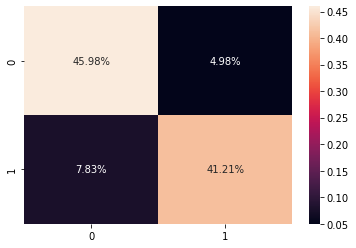

In [39]:
build_conf_mat(y_val_arr, pred_tree, 'DecisionTree')

In [43]:

print("Number of mislabeled points out of a total %d points : %d" % (len(x_train_arr), (y_val_arr != pred_tree).sum()))

Number of mislabeled points out of a total 140000 points : 7687


Feature importances:
[2.67020652e-02 5.88920681e-01 1.22041624e-04 2.48855945e-01
 7.10776854e-02 3.98967671e-03 5.91457018e-04 0.00000000e+00
 5.97404481e-02]


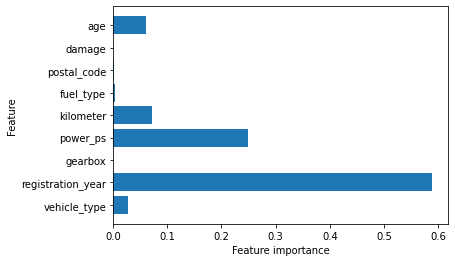

In [45]:
#feature selection 
print("Feature importances:\n{}".format(tr.feature_importances_))

def plot_features(model):
    plt.barh(range(9), model.feature_importances_, align='center')
    plt.yticks(np.arange(9), x_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_features(tr)
plt.show()


In [46]:
!pip install graphviz

In [ ]:
#drawing decision tree

from sklearn.tree import export_graphviz
import graphviz

dotd = export_graphviz(tr, out_file= None, class_names=["below 3.5k", "over 3.5k"], feature_names= x.columns, impurity=False, filled=True)
dt_graph = graphviz.Source(dotd)
dt_graph


In [12]:
x_train_arr = np.array(x_train)
y_train_arr = np.array(y_train)
x_val_arr = np.array(x_val)
y_val_arr = np.array(y_val)

# x_train_arr = x_train_arr.reshape(-1,1)
# y_train_arr = y_train_arr.reshape(-1,1)
# x_val_arr = x_val_arr.reshape(-1,1)
# y_val_arr = y_val_arr.reshape(-1,1)

In [13]:
#SVM
from sklearn import svm

SVM_linear = svm.LinearSVC()
SVM = svm.SVC(gamma='auto')

lin_svm_fit = SVM_linear.fit(x_train_arr, y_train_arr)
svm_fit = SVM.fit(x_train_arr, y_train_arr)

svm_lin_pred = lin_svm_fit.predict(x_val_arr)
svm_pred = svm_fit.predict(x_val_arr)

print('linear SVM accuracy: ', lin_svm_fit.score(x_val_arr, y_val_arr))
print('SVM accuracy: ', svm_fit.score(x_val_arr, y_val_arr))


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


linear SVM accuracy:  0.5103166666666666
SVM accuracy:  0.79455


In [17]:
calc_precision(y_val_arr, svm_lin_pred, 'linear SVM')
print('-----------------------------')
calc_precision(y_val_arr, svm_pred, 'SVM')


Precision: 0.510  for  linear SVM
Recall: 0.510 for  linear SVM
-----------------------------
Precision: 0.795  for  SVM
Recall: 0.795 for  SVM


linear SVM  Confusion Matrix: 
   TP&FN  FP&TN
0  30532     47
1  29334     87


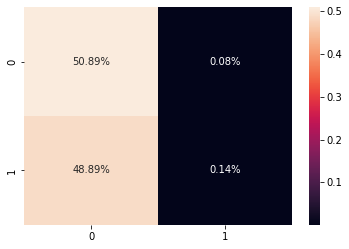

In [20]:
build_conf_mat(y_val_arr, svm_lin_pred, 'linear SVM')

SVM  Confusion Matrix: 
   TP&FN  FP&TN
0  24555   6024
1   6303  23118


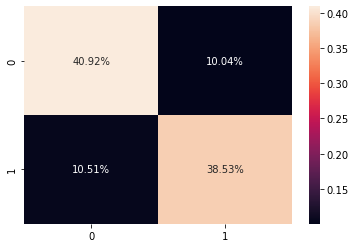

In [21]:
build_conf_mat(y_val_arr, svm_pred, 'SVM')

In [22]:
print("Number of mislabeled points out of a total %d points in Linear SVM : %d" % (len(x_train_arr), (y_val_arr != svm_lin_pred).sum()))
print("Number of mislabeled points out of a total %d points in SVM : %d" % (len(x_train_arr), (y_val_arr != svm_pred).sum()))


Number of mislabeled points out of a total 140000 points in Linear SVM : 29381
Number of mislabeled points out of a total 140000 points in SVM : 12327


### Random Forest

In [23]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF_fit = RF.fit(x_train, y_train)
RF_pred = RF_fit.predict(x_val)

print('random forest accuracy: ', RF_fit.score(x_val,y_val))

random forest accuracy:  0.8034333333333333


In [24]:
calc_precision(y_val_arr, RF_pred, 'RF')


Precision: 0.803  for  RF
Recall: 0.803 for  RF


RF  Confusion Matrix: 
   TP&FN  FP&TN
0  24303   6276
1   5518  23903


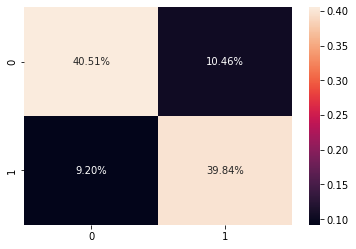

In [25]:
build_conf_mat(y_val_arr, RF_pred, 'RF')

In [27]:
print("Number of mislabeled points out of a total %d points in RF : %d" % (len(x_train), (y_val != RF_pred).sum()))


Number of mislabeled points out of a total 140000 points in RF : 11794


### Logistic Regression

In [28]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(x_train, y_train)
logreg_pred = LR.predict(x_val)

print('logistic regression accuracy: ', LR.score(x_val, y_val))

logistic regression accuracy:  0.5319833333333334


In [29]:
calc_precision(y_val_arr, logreg_pred, 'LogisticReg')


Precision: 0.532  for  LogisticReg
Recall: 0.532 for  LogisticReg


LogisitcReg  Confusion Matrix: 
   TP&FN  FP&TN
0  19272  11307
1  16774  12647


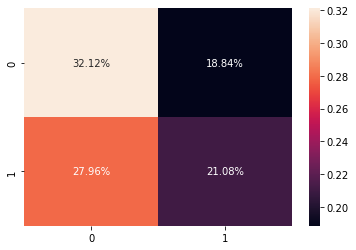

In [30]:
build_conf_mat(y_val_arr, logreg_pred, 'LogisitcReg')

In [31]:
print("Number of mislabeled points out of a total %d points in Logistic Regression : %d" % (len(x_train_arr), (y_val_arr != logreg_pred).sum()))


Number of mislabeled points out of a total 140000 points in Logistic Regression : 28081


### MLP Classifier - Neural Network 

In [34]:
#NN
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
nn_fit = NN.fit(x_train, y_train)
nn_pred = NN.predict(x_val)

print('MLP accuracy: ', nn_fit.score(x_val, y_val))


MLP accuracy:  0.50965


In [35]:
calc_precision(y_val_arr, nn_pred, 'MLP')


Precision: 0.510  for  MLP
Recall: 0.510 for  MLP


MLP  Confusion Matrix: 
   TP&FN  FP&TN
0  30579      0
1  29421      0


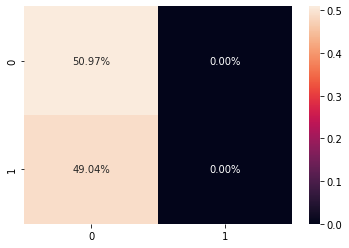

In [36]:
build_conf_mat(y_val_arr, nn_pred, 'MLP')

In [37]:
print("Number of mislabeled points out of a total %d points in MLP: %d" % (len(x_train), (y_val != nn_pred).sum()))


Number of mislabeled points out of a total 140000 points in MLP: 29421


In [38]:
classification_results = {
    'KNN_accuracy': 0.77,
    'KNN_precision': 0.765,
    'KNN_recall': 0.765,
    'DT_accuracy': 0.87,
    'DT_precision': 0.89,
    'DT_recall': 0.90,
    'LinearSVM_accuracy': 0.51,
    'LinearSVM_precision': 0.510,
    'LineaerSVM_recall': 0.510,
    'SVM_accuracy': 0.79,
    'SVM_precision': 0.795,
    'SVM_recall': 0.795,
    'RF_accuracy': 0.80,
    'RF_precision': 0.803,
    'RF_recall': 0.803,
    'LogisticReg_Accuracy': 0.53,
    'LogisticReg_precision': 0.532,
    'LogisticReg_recall': 0.532,
    'MLP_accuracy': 0.51,
    'MLP_precision': 0.51,
    'MLP_recall':  0.51
}

df_results = pd.DataFrame.from_dict(classification_results, orient = 'index', columns = ['results'])

In [39]:
df_results

,results
KNN_accuracy,0.770
KNN_precision,0.765
KNN_recall,0.765
DT_accuracy,0.870
DT_precision,0.890
DT_recall,0.900
LinearSVM_accuracy,0.510
LinearSVM_precision,0.510
LineaerSVM_recall,0.510
SVM_accuracy,0.790


Best Accuracy: Decision Tree


In [42]:
total = 140000

dt_miss = round(7687/total, 2)
dt_hit = round((total - 7687)/total, 2)

lin_svm_miss = round(29381/total, 2)
lin_svm_hit = round((total - 29381)/total, 2)

svm_miss = round(12327/total, 2)
svm_hit = round((total - 12327)/total, 2)

rf_miss = round(11794/total, 2)
rf_hit = round((total - 11794)/total, 2)

logReg_miss = round(28081/total, 2)
logReg_hit = round((total - 28081)/total, 2)

mlp_miss = round(29421/total, 2)
mlp_hit = round((total - 29421)/total,2)

final_hit_miss_dict = {
    'DTmiss': dt_miss,
    'DThit' : dt_hit, 
    'linSVMmiss': lin_svm_miss,
    'linSVMhit': lin_svm_hit,
    'svmMiss': svm_miss,
    'svmHit': svm_hit,
    'rfMiss': rf_miss,
    'rfHit': rf_hit,
    'logRegMiss': logReg_miss,
    'logRegHit': logReg_hit,
    'MLPmiss': mlp_miss,
    'MLPhit': mlp_hit
}

df_hit_or_miss = pd.DataFrame.from_dict(final_hit_miss_dict, orient = 'index', columns = ['percent value'])
df_hit_or_miss

,percent value
DTmiss,0.05
DThit,0.95
linSVMmiss,0.21
linSVMhit,0.79
svmMiss,0.09
svmHit,0.91
rfMiss,0.08
rfHit,0.92
logRegMiss,0.20
logRegHit,0.80


As we can see from this table, Decision Tree only missclassifies 5% of the time, and accurately classifies 95% of the time. 